In [ ]:
#!pip install gspread oauth2client
import gspread
from oauth2client.service_account import ServiceAccountCredentials
from __future__ import print_function
import os, sys
import pickle
import os.path
import io
import json

import numpy as np
import pandas as pd
import scipy as sp
import scipy.stats as scs

from matplotlib import pyplot as plt
import seaborn as sns
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


In [ ]:
downloaded = drive.CreateFile({'id':"1A3xjHXxEP-CEqUe7ujie8hk25XhEshLd"})   # replace the id with id of file you want to access
downloaded.GetContentFile('week2_DS.xlsx') 
data = pd.read_excel('week2_DS.xlsx')

In [ ]:
#data.to_pickle("./telecomm.pkl")
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150001 entries, 0 to 150000
Data columns (total 55 columns):
 #   Column                                    Non-Null Count   Dtype         
---  ------                                    --------------   -----         
 0   Bearer Id                                 150001 non-null  object        
 1   Start                                     150000 non-null  datetime64[ns]
 2   Start ms                                  150000 non-null  float64       
 3   End                                       150000 non-null  datetime64[ns]
 4   End ms                                    150000 non-null  float64       
 5   Dur. (ms)                                 150000 non-null  float64       
 6   IMSI                                      149431 non-null  float64       
 7   MSISDN/Number                             148935 non-null  float64       
 8   IMEI                                      149429 non-null  float64       
 9   Last Location N

#Task 1

In [ ]:
#drop columns uneccesary to our analysis-->Ds(ms) is repeated
content = data.drop(columns = ['Bearer Id','Start' , 'Start ms' ,'Avg Bearer TP UL (kbps)', 'Avg Bearer TP DL (kbps)' ,'TCP DL Retrans. Vol (Bytes)', 'TCP UL Retrans. Vol (Bytes)' ,'End' , 'End ms' , 'Last Location Name' , 'Avg RTT DL (ms)' , 'Avg RTT UL (ms)' , 'DL TP < 50 Kbps (%)' , '50 Kbps < DL TP < 250 Kbps (%)' , '250 Kbps < DL TP < 1 Mbps (%)' , 'DL TP > 1 Mbps (%)' , 'UL TP < 10 Kbps (%)' , '10 Kbps < UL TP < 50 Kbps (%)' , '50 Kbps < UL TP < 300 Kbps (%)' , 'UL TP > 300 Kbps (%)' , 'Dur. (ms)' , 'HTTP DL (Bytes)' ,  'HTTP UL (Bytes)' ,  'Nb of sec with 125000B < Vol DL' , 'Nb of sec with 1250B < Vol UL < 6250B' , 'Nb of sec with 31250B < Vol DL < 125000B' ,'Nb of sec with 37500B < Vol UL' ,'Nb of sec with 6250B < Vol DL < 31250B' ,'Nb of sec with 6250B < Vol UL < 37500B' , 'Nb of sec with Vol DL < 6250B' , 'Nb of sec with Vol UL < 1250B'])
#rename the columns
df =content.rename(columns={'IMSI': 'subscriber_id' , 'MSISDN/Number':'Number'})
#deal with Na values
df = df.dropna(subset=['Number'])
df["IMEI"].fillna( method ='ffill', inplace = True) 

pd.set_option('display.float_format', lambda x: '%.5f' % x)
df['Netflix_volume(bytes)'] = df['Netflix DL (Bytes)'] + df['Netflix UL (Bytes)']
df['Gaming_volume(bytes)'] = df['Gaming DL (Bytes)'] + df['Gaming UL (Bytes)']
df['Other_volume(bytes)'] = df['Other DL (Bytes)'] + df['Other UL (Bytes)']
df['Youtube_volume(bytes)'] = df['Youtube DL (Bytes)'] + df['Youtube UL (Bytes)']
df['Social_media_volume(bytes)'] = df['Social Media DL (Bytes)'] + df['Social Media UL (Bytes)']
df['Google_volume(bytes)'] = df['Google UL (Bytes)'] + df['Google DL (Bytes)']
df['Email_volume'] = df['Email DL (Bytes)'] + df['Email UL (Bytes)']
df['Total_volume'] = df['Total DL (Bytes)'] + df['Total UL (Bytes)']
df['Session_duration'] = df['Activity Duration DL (ms)']
total_duration = df['Dur. (ms).1'].sum()
total_download = df['Total DL (Bytes)'].sum()
total_upload = df['Total UL (Bytes)'].sum()
df.describe(include='all')

        subscriber_id  Number  ...  Total_volume  Session_duration
0               False   False  ...         False             False
1               False   False  ...         False             False
2               False   False  ...         False             False
3               False   False  ...         False             False
4               False   False  ...         False             False
...               ...     ...  ...           ...               ...
149995          False   False  ...         False             False
149996          False   False  ...         False             False
149997          False   False  ...         False             False
149998          False   False  ...         False             False
149999          False   False  ...         False             False

[148935 rows x 33 columns]


In [ ]:
df_num = df.select_dtypes(include=[np.number])


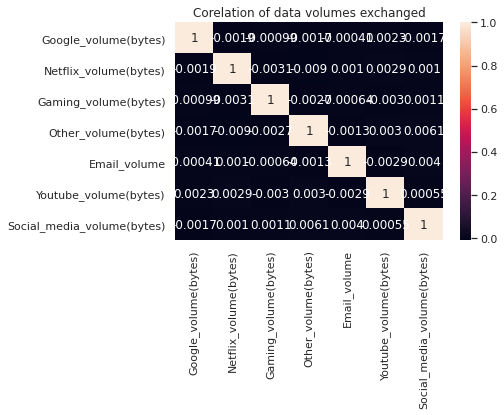

In [ ]:
#establis correlation of application data volume
volumes_df = df[['Google_volume(bytes)','Netflix_volume(bytes)' ,'Gaming_volume(bytes)' , 'Other_volume(bytes)' , 'Email_volume' , 'Youtube_volume(bytes)' , 'Social_media_volume(bytes)']].copy()
corrMatrix = volumes_df.corr()
sns.set()
plt.title('Corelation of data volumes exchanged')
sns.heatmap(corrMatrix, annot=True)
plt.show()

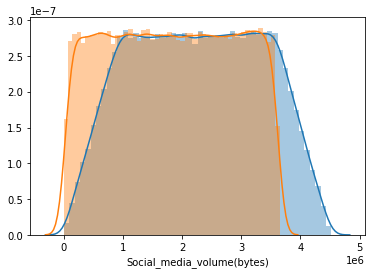

In [ ]:
sns.distplot(df['Email_volume'])
#sns.distplot(df['Google_volume(bytes)'])

sns.distplot(df['Social_media_volume(bytes)'])

In [ ]:
#pca
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
x = StandardScaler().fit_transform(df_num) # normalizing the features
x.shape
#check the mean 
np.mean(x),np.std(x)
#standard deviation from the mean is normal 
#
pca = PCA(n_components=5)
principalComponents_ = pca.fit_transform(x)
pca_data = pd.DataFrame(x,columns=['subscriber_id' , 'Number','IMEI', 'Activity Duration DL (ms)' , 'Activity Duration UL (ms)', 'Dur. (ms).1' , 'Social Media DL (Bytes)' ,'Social Media UL (Bytes)' , 'Google DL (Bytes)' ,'Google UL (Bytes)' , 'Email DL (Bytes)' , 'Email UL (Bytes)' ,'Youtube DL (Bytes)', 'Youtube UL (Bytes)' , 'Netflix DL (Bytes)' , 'Netflix UL (Bytes)' , 'Gaming DL (Bytes)' , 'Gaming UL (Bytes)', 'Other DL (Bytes)' , 'Other UL (Bytes)' , 'Total UL (Bytes)' ,'Total DL (Bytes)' , 'Total DL (Bytes)' , 'Gaming_volume(bytes)' , 'Other_volume(bytes)' , 'Youtube_volume(bytes)' , 'Social_media_volume(bytes)' , 'Google_volume(bytes)', 'Email_volume' , 'Total_volume' , 'Session_duration' ])


# Task 2

In [153]:
#create a grouped object by number 
from IPython.display import HTML

customer_sessions = df.groupby("Number").size().reset_index(name='counts')
volume_exchanged = df.groupby("Number").agg({'Total_volume':max})
session_time = df.groupby("Number")[['Dur. (ms).1']].max()

#get top 10 user with most sessions, most volume exchanged and most time spent 
most_frequent_cust = customer_sessions.sort_values(by=['counts'] , ascending=False).head(10)
most_volume_exchanged = volume_exchanged.sort_values(by='Total_volume', ascending=False).head(10)
most_session_duration = session_time.sort_values(by='Dur. (ms).1', ascending=False).head(10)
most_frequent_cust['Number'] = most_frequent_cust['Number'].astype(np.int64)
HTML(most_frequent_cust.to_html(index=False))
HTML(most_volume_exchanged.to_html())
HTML(most_session_duration.to_html())
#kmeans cluster

#get top 10 users per application
top_10_Netflix = df.sort_values(by='Netflix_volume(bytes)' , ascending=False).head(10)
top_10_Netflix['subscriber_id'].astype(np.int64)

top_10_Google = df.sort_values(by='Google_volume(bytes)' , ascending=False).head(10)
top_10_Google['subscriber_id'].astype(np.int64)

top_10_Gaming = df.sort_values(by='Gaming_volume(bytes)' , ascending=False).head(10)
top_10_Gaming['subscriber_id'].astype(np.int64)

top_10_Youtube = df.sort_values(by='Youtube_volume(bytes)' , ascending=False).head(10)
top_10_Youtube['subscriber_id'].astype(np.int64)

top_10_Social_media = df.sort_values(by='Social_media_volume(bytes)' , ascending=False).head(10)
top_10_Social_media['subscriber_id'].astype(np.int64)

top_10_Email = df.sort_values(by='Email_volume' , ascending=False).head(10)
top_10_Email['subscriber_id'].astype(np.int64)

top_10_Netflix , top_10_Gaming , top_10_Youtube , top_10_Google , top_10_Email
#visualize minimum , maximum , average and total for engagement 

(               subscriber_id  ...  Session_duration
 60136  208201771746142.00000  ...     3336995.00000
 134942 208200853537209.00000  ...       41417.00000
 38586  208201771753312.00000  ...    11220726.00000
 25959  208201908521089.00000  ...       41795.00000
 72644  208201904762245.00000  ...      123769.00000
 56035  208201449435032.00000  ...       57303.00000
 134936 208201908694005.00000  ...       41073.00000
 54868  208201446394265.00000  ...       33300.00000
 18413  208200853658112.00000  ...     1345158.00000
 86468  208201009383164.00000  ...         657.00000
 
 [10 rows x 33 columns],                subscriber_id  ...  Session_duration
 82105  208200313692034.00000  ...       30276.00000
 76363  208201907197047.00000  ...     2959856.00000
 2886   208201009698123.00000  ...     9575060.00000
 44290  208200314626223.00000  ...       13952.00000
 66388  208201447995117.00000  ...       30656.00000
 125033 208201908719243.00000  ...           0.00000
 11706  208201008483

In [ ]:
#k-means


# Task 3

In [143]:
content1 = data.drop(columns = ['Bearer Id','Dur. (ms).1' ,'Other DL (Bytes)' , 'Other UL (Bytes)' ,'Gaming DL (Bytes)' , 'Gaming UL (Bytes)', 'Netflix DL (Bytes)', 'Netflix UL (Bytes)' ,'Youtube DL (Bytes)' , 'Youtube UL (Bytes)' ,'Email DL (Bytes)', 'Email UL (Bytes)','Google UL (Bytes)' ,'Google DL (Bytes)' ,'Social Media DL (Bytes)' , 'Social Media UL (Bytes)','Handset Manufacturer', 'Start' , 'Start ms' ,'End' , 'End ms' , 'Last Location Name' , 'DL TP < 50 Kbps (%)' ,'Activity Duration DL (ms)' ,'Activity Duration UL (ms)',  '50 Kbps < DL TP < 250 Kbps (%)' , '250 Kbps < DL TP < 1 Mbps (%)' , 'DL TP > 1 Mbps (%)' , 'UL TP < 10 Kbps (%)' , '10 Kbps < UL TP < 50 Kbps (%)' , '50 Kbps < UL TP < 300 Kbps (%)' , 'UL TP > 300 Kbps (%)' , 'Dur. (ms)' , 'HTTP DL (Bytes)' ,  'HTTP UL (Bytes)' ,  'Nb of sec with 125000B < Vol DL' , 'Nb of sec with 1250B < Vol UL < 6250B' , 'Nb of sec with 31250B < Vol DL < 125000B' ,'Nb of sec with 37500B < Vol UL' ,'Nb of sec with 6250B < Vol DL < 31250B' ,'Nb of sec with 6250B < Vol UL < 37500B' , 'Nb of sec with Vol DL < 6250B' , 'Nb of sec with Vol UL < 1250B'])

#deal with missing data
content1.fillna(method ='pad') 

#calculated total columns
content1['Total_TCP_Trans'] = content1['TCP DL Retrans. Vol (Bytes)'] + content1['TCP UL Retrans. Vol (Bytes)']
content1['Tot_avg_RTT'] = content1['Avg RTT DL (ms)'] + content1['Avg RTT UL (ms)']
content1['Tot_throughput'] = content1['Total UL (Bytes)'] + content1['Total DL (Bytes)']

#calculate averages for groups
avg_rtt = content1.groupby("MSISDN/Number")['Tot_avg_RTT' ].mean()
avg_tcp = content1.groupby("MSISDN/Number")['Total_TCP_Trans' ].mean()
avg_throughput = content1.groupby("MSISDN/Number")['Tot_throughput' ].mean()

#get frequencies
rtt_freq = content1['Tot_avg_RTT'].value_counts().to_frame()
tcp_freq = content1['Total_TCP_Trans'].value_counts().to_frame()
throughput_freq = content1['Tot_throughput'].value_counts().to_frame()

#get top and bottom values 
top_rtt = content1.nlargest(10,'Tot_avg_RTT')
bottom_rtt = content1.nsmallest(10,'Tot_avg_RTT')

top_tcp = content1.nlargest(10 , 'Total_TCP_Trans')
bottom_tcp = content1.nsmallest(10 , 'Total_TCP_Trans')

top_throughput = content1.nlargest(10 , 'Tot_throughput')
bottom_throughput = content1.nsmallest(10 , 'Tot_throughput')